#### This notebook presents how to perform maximum-likelihood parameter estimation for a single neuron.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))
sys.path.append(os.path.join(os.getcwd(),"..","code"))
data_path = os.path.join(os.getcwd(),'..','data')
sys.path.append(data_path)

In [4]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [5]:
import imp
imp.reload(filters)
imp.reload(lk)
imp.reload(auxfun)
imp.reload(PP)

<module 'PoissonProcessClasses' from '/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py'>

Reading input-output data:

In [6]:
# reading stimulus
Stim = np.array(pd.read_csv(os.path.join(data_path,'Stim.csv'),header = None))
# reading location of spikes
tsp = np.hstack(np.array(pd.read_csv(os.path.join(data_path,'tsp.csv'),header = None)))

Extracting a spike train from spike positions:

In [7]:
dt = 0.01
tsp_int = np.ceil((tsp - dt*0.001)/dt)
tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
tsp_int = tsp_int.astype(int)
y = np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)]).astype(int)

Displaying the spike train a subset of the spike train:

Creating filters:

In [8]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [9]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4,'absref':0.}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

*Conditional Intensity* (spike rate):

$$\lambda_{\beta} = \exp(K(\beta_k)*Stim + H(\beta_h)*y)$$

($\beta_k$ and $\beta_h$ are the unknown coefficients of the filters).

Since the convolution is a linear operation the intensity can be written in the following form:

$$\lambda_{\beta} = \exp(M_k \beta_k + M_h\beta_h),$$

where $M_k$ and $M_h$ are matrices depending on the stimulus and the response correspondingly.

Creating a matrix of covariates:

In [10]:
M_k = lk.construct_M_k(Stim,K,dt)

In [11]:
M_h = lk.construct_M_h(tsp,H_orth,dt,Stim)

Combining $M_k$ and $M_h$ into one covariate matrix:

In [12]:
M = np.hstack((M_k,M_h))

The conditional intensity becomes:
$$ \lambda_{\beta} = \exp(M\beta) $$

($\beta$ contains all the unknown parameters).

Create a Poisson process model with this intensity:

In [13]:
model = PP.PPModel(M.T,dt = dt)

Setting initial parameters for optimization:

In [14]:
coeff_k0 = np.array([0.32967,
    0.59341,
    1.36703,
    1.78901,
    1.33187,
    0.66788,
   -1.69981,
    0.44975,
   -0.12650,
   -0.05882])
# coeff_h0 = np.zeros((5,))
coeff_h0 = np.array([-15.18,38.24,-67.58,-14.06,-3.36])

pars0 = np.hstack((coeff_k0,coeff_h0))

Fitting the likelihood (here using Nelder-Mead method with 10000 iterations):

In [15]:
res = model.fit(y,start_coef = pars0,maxiter = 10000,method = 'Nelder-Mead')

Optimization terminated successfully.
         Current function value: -371.960106
         Iterations: 6695
         Function evaluations: 8880


/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:186: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if start_coef==None:
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:358: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)


Optimization results:

In [23]:
print(res)

 success: True
     fun: -371.96010645632077
       x: array([  8.94213799e-02,  -7.44502967e-02,   7.05874341e-02,
        -2.13777082e-02,   1.75573019e-02,  -1.28730700e-02,
         5.97086316e-02,  -6.84510812e-02,   7.50112856e-02,
        -6.55383137e-02,  -1.48651972e+02,   2.52287943e+01,
        -1.13867819e+02,   1.32691348e+02,  -6.61505099e+00])
  status: 0
 message: 'Optimization terminated successfully.'
    nfev: 8880
     nit: 6695


Creating the predicted filters:

In [24]:
k_coeff_predicted = res.x[:10]
h_coeff_predicted = res.x[10:]

In [25]:
kfilter_predicted = np.dot(K,k_coeff_predicted)
hfilter_predicted = np.dot(H_orth,h_coeff_predicted)

In [26]:
k_coeff = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])
h_coeff = np.array([-10, -5, 0, 2, -2])

kfilter_true = np.dot(K,k_coeff)
hfilter_true = np.dot(H_orth,h_coeff)

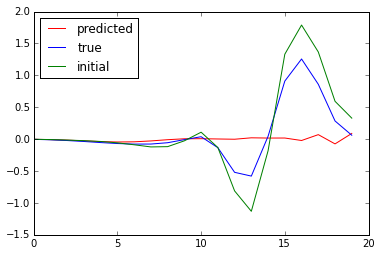

In [27]:
plt.plot(kfilter_predicted,color = "r",label = 'predicted')
plt.hold(True)
plt.plot(kfilter_true,color= "blue",label = 'true')
plt.hold(True)
plt.plot(np.dot(K,coeff_k0),color = "g",label = 'initial')
plt.legend(loc = 'upper left')

In [28]:
hfilter_true = np.dot(H_orth,np.array([-15.18,38.24,-67.58,-14.06,-3.36]))

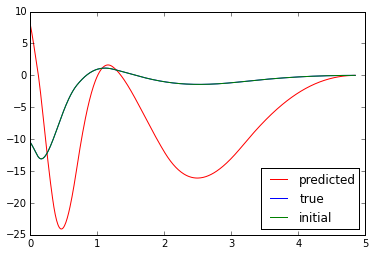

In [29]:
plt.plot(ht_domain,hfilter_predicted,color = "r",label = 'predicted')
plt.hold(True)
plt.plot(ht_domain,hfilter_true,color = "b",label = 'true')
plt.hold(True)
plt.plot(ht_domain,np.dot(H_orth,coeff_h0),color = "g",label = 'initial')
plt.legend(loc = 'lower right')